In [1]:
# 导入必要的库
import os
import numpy as np
import matplotlib.pyplot as plt
import mindspore
from mindspore import nn
from mindspore import context, dataset
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset
from mindspore import save_checkpoint
# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False     # 用来正常显示负号

In [2]:
# 设置运行模式为图模式，提高性能
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

[WARNING] ME(45523:8531184768,MainProcess):2025-05-02-16:21:56.482.183 [mindspore/context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


In [3]:
# 下载MNIST数据集(如果没有)
def download_mnist():
    """下载MNIST数据集"""
    if not os.path.exists('MNIST_Data'):
        from download import download

        url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
              "notebook/datasets/MNIST_Data.zip"
        path = download(url, "./", kind="zip", replace=True)
        print("数据集下载完成")

In [4]:
# 准备MNIST数据集
def prepare_dataset():
    """准备MNIST数据集，返回处理好的训练集和测试集"""
    # 加载MNIST数据集
    train_dataset = MnistDataset('MNIST_Data/train')
    test_dataset = MnistDataset('MNIST_Data/test')

    print(f"训练集大小: {train_dataset.get_dataset_size()}")
    print(f"测试集大小: {test_dataset.get_dataset_size()}")
    print(f"数据集列名: {train_dataset.get_col_names()}")

    # 数据预处理和批处理
    def datapipe(dataset, batch_size):
        # 图像预处理: 缩放、归一化和维度变换
        image_transforms = [
            vision.Rescale(1.0 / 255.0, 0),  # 将像素值缩放到[0, 1]范围
            vision.Normalize(mean=(0.1307,), std=(0.3081,)),  # 标准化处理
            vision.HWC2CHW()  # 将图像格式从HWC转换为CHW
        ]
        # 标签转换为int32类型
        label_transform = transforms.TypeCast(mindspore.int32)

        # 应用数据转换
        dataset = dataset.map(image_transforms, 'image')
        dataset = dataset.map(label_transform, 'label')
        # 设置批处理大小
        dataset = dataset.batch(batch_size)
        return dataset

    # 设置批处理大小为64
    batch_size = 64
    train_dataset = datapipe(train_dataset, batch_size)
    test_dataset = datapipe(test_dataset, batch_size)
    
    # 查看处理后的数据格式
    for image, label in test_dataset.create_tuple_iterator():
        print(f"图像形状 [N, C, H, W]: {image.shape} {image.dtype}")
        print(f"标签形状: {label.shape} {label.dtype}")
        break
        
    return train_dataset, test_dataset

In [5]:
# 定义LeNet5模型
class LeNet5(nn.Cell):
    """
    LeNet5模型定义
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        # 卷积层1，输入通道1，输出通道6，卷积核大小5x5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, pad_mode='valid')
        # 最大池化层1，核大小2x2，步长2
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 卷积层2，输入通道6，输出通道16，卷积核大小5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, pad_mode='valid')
        # 最大池化层2，核大小2x2，步长2
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 展平层
        self.flatten = nn.Flatten()
        # 全连接层1，输入4x4x16=256，输出120
        self.fc1 = nn.Dense(16 * 4 * 4, 120)
        # 激活函数
        self.relu = nn.ReLU()
        # 全连接层2，输入120，输出84
        self.fc2 = nn.Dense(120, 84)
        # 输出层，输入84，输出10（10个数字类别）
        self.fc3 = nn.Dense(84, 10)

    def construct(self, x):
        # 第一个卷积-池化模块
        x = self.conv1(x)              # 输出: [batch_size, 6, 24, 24]
        x = self.relu(x)
        x = self.max_pool1(x)          # 输出: [batch_size, 6, 12, 12]
        
        # 第二个卷积-池化模块
        x = self.conv2(x)              # 输出: [batch_size, 16, 8, 8]
        x = self.relu(x)
        x = self.max_pool2(x)          # 输出: [batch_size, 16, 4, 4]
        
        # 展平操作
        x = self.flatten(x)            # 输出: [batch_size, 16*4*4]
        
        # 全连接层
        x = self.fc1(x)                # 输出: [batch_size, 120]
        x = self.relu(x)
        x = self.fc2(x)                # 输出: [batch_size, 84]
        x = self.relu(x)
        x = self.fc3(x)                # 输出: [batch_size, 10]
        
        return x

In [6]:
# 定义训练和评估函数
def train_model(model, train_dataset, test_dataset, epochs=5):
    # 定义损失函数和优化器
    loss_fn = nn.CrossEntropyLoss() # 交叉熵损失函数，用于分类问题
    optimizer = nn.SGD(model.trainable_params(), learning_rate=0.01, momentum=0.9) # 随机梯度下降优化器

    # 定义前向计算函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # 定义梯度计算函数
    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # 定义单步训练函数
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    # 定义训练循环
    def train_loop(model, dataset, epochs):
        model.set_train()  # 设置模型为训练模式
        steps = dataset.get_dataset_size()
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            loss_total = 0
            
            for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
                loss = train_step(data, label) # 这一步是计算损失，同时更新模型参数
                loss_total += loss.asnumpy()
                
                if batch % 100 == 0:
                    loss_val = loss.asnumpy()
                    print(f"    batch {batch}/{steps}: loss={loss_val:.4f}")
                    
            avg_loss = loss_total / steps
            print(f"Epoch {epoch+1} 平均损失: {avg_loss:.4f}\n")
    
    # 定义评估函数
    def test_loop(model, dataset):
        model.set_train(False)  # 设置模型为评估模式
        
        correct = 0
        total_samples = 0
        
        for data, label in dataset.create_tuple_iterator():
            # 前向计算
            logits = model(data)
            # 计算预测结果
            pred = logits.argmax(1)
            # 统计正确预测的样本数
            correct += (pred == label).asnumpy().sum()
            total_samples += label.shape[0]
        
        # 计算准确率
        accuracy = correct / total_samples
        print(f"测试集准确率: {accuracy*100:.2f}%")
        return accuracy

    # 执行训练和评估
    print("开始训练...")
    train_loop(model, train_dataset, epochs)
    print("训练完成，开始评估...")
    accuracy = test_loop(model, test_dataset)
    
    return accuracy

In [7]:
# 保存模型
def save_model(model, filename="lenet5_mnist.ckpt"):
    """保存模型"""
    save_checkpoint(model, filename)
    print(f"模型已保存到 {filename}")

In [8]:
def visualize_results(model, test_dataset):
    """可视化预测结果"""
    # 获取一批测试数据
    for images, labels in test_dataset.create_tuple_iterator():
        break

    # 获取预测结果
    model.set_train(False)
    output = model(images)
    predictions = output.argmax(1).asnumpy()
    images = images.asnumpy()
    labels = labels.asnumpy()

    # 显示部分样本的预测结果
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # 转换图像格式并显示
        plt.imshow(images[i][0], cmap=plt.cm.binary)
        # 预测正确显示绿色，错误显示红色
        if predictions[i]==labels[i]:
            plt.xlabel(f"预测: {predictions[i]}", color='green')
        else:
            plt.xlabel(f"预测: {predictions[i]}, 实际: {labels[i]}", color='red')
    plt.tight_layout()
    plt.savefig('lenet5_predictions.png')
    plt.show()

训练集大小: 60000
测试集大小: 10000
数据集列名: ['image', 'label']
图像形状 [N, C, H, W]: (64, 1, 28, 28) Float32
标签形状: (64,) Int32
LeNet5模型结构:
LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x17739c4c0>, bias_init=None, format=NCHW>
  (max_pool1): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x105c00c70>, bias_init=None, format=NCHW>
  (max_pool2): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  (fc1): Dense<input_channels=256, output_channels=120, has_bias=True>
  (relu): ReLU<>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_chan

[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:21:56.842.163 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py]
[WARNING] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:21:56.842.172 [mindspore/core/utils/info.cc:121] ToString] The file '/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py' may not exists.
[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:21:56.860.569 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py]
[WARNING] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:21:56.860.575 [mindspore/core/utils/info.cc:121] ToString] The file '/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py' may not exists.
[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:21:56.860.586 [mindspore/core/utils/file_utils.cc:253] Ge

    batch 0/938: loss=2.2995
    batch 100/938: loss=0.4874
    batch 200/938: loss=0.1350
    batch 300/938: loss=0.0456
    batch 400/938: loss=0.1691
    batch 500/938: loss=0.2658
    batch 600/938: loss=0.0922
    batch 700/938: loss=0.0356
    batch 800/938: loss=0.1602
    batch 900/938: loss=0.0147


[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:01.513.596 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py]
[WARNING] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:01.513.608 [mindspore/core/utils/info.cc:121] ToString] The file '/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py' may not exists.
[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:01.531.738 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py]
[WARNING] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:01.531.746 [mindspore/core/utils/info.cc:121] ToString] The file '/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/943210774.py' may not exists.
[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:01.531.758 [mindspore/core/utils/file_utils.cc:253] Ge

Epoch 1 平均损失: 0.2842

Epoch 2/5
    batch 0/938: loss=0.0249
    batch 100/938: loss=0.0574
    batch 200/938: loss=0.1589
    batch 300/938: loss=0.0169
    batch 400/938: loss=0.0140
    batch 500/938: loss=0.1483
    batch 600/938: loss=0.1525
    batch 700/938: loss=0.0413
    batch 800/938: loss=0.1190
    batch 900/938: loss=0.0270
Epoch 2 平均损失: 0.0657

Epoch 3/5
    batch 0/938: loss=0.0513
    batch 100/938: loss=0.1949
    batch 200/938: loss=0.0307
    batch 300/938: loss=0.0479
    batch 400/938: loss=0.0302
    batch 500/938: loss=0.0020
    batch 600/938: loss=0.0178
    batch 700/938: loss=0.0473
    batch 800/938: loss=0.0260
    batch 900/938: loss=0.0514
Epoch 3 平均损失: 0.0468

Epoch 4/5
    batch 0/938: loss=0.0137
    batch 100/938: loss=0.0059
    batch 200/938: loss=0.0006
    batch 300/938: loss=0.0268
    batch 400/938: loss=0.1197
    batch 500/938: loss=0.1191
    batch 600/938: loss=0.0091
    batch 700/938: loss=0.0662
    batch 800/938: loss=0.0159
    batch 9

[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:20.184.381 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/1225346843.py]
[WARNING] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:20.184.391 [mindspore/core/utils/info.cc:121] ToString] The file '/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/1225346843.py' may not exists.
[ERROR] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:20.513.781 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/1225346843.py]
[WARNING] CORE(45523,0x1fc7f8c80,python):2025-05-02-16:22:20.513.792 [mindspore/core/utils/info.cc:121] ToString] The file '/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_45523/1225346843.py' may not exists.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


测试集准确率: 98.91%
模型已保存到 lenet5_mnist.ckpt


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

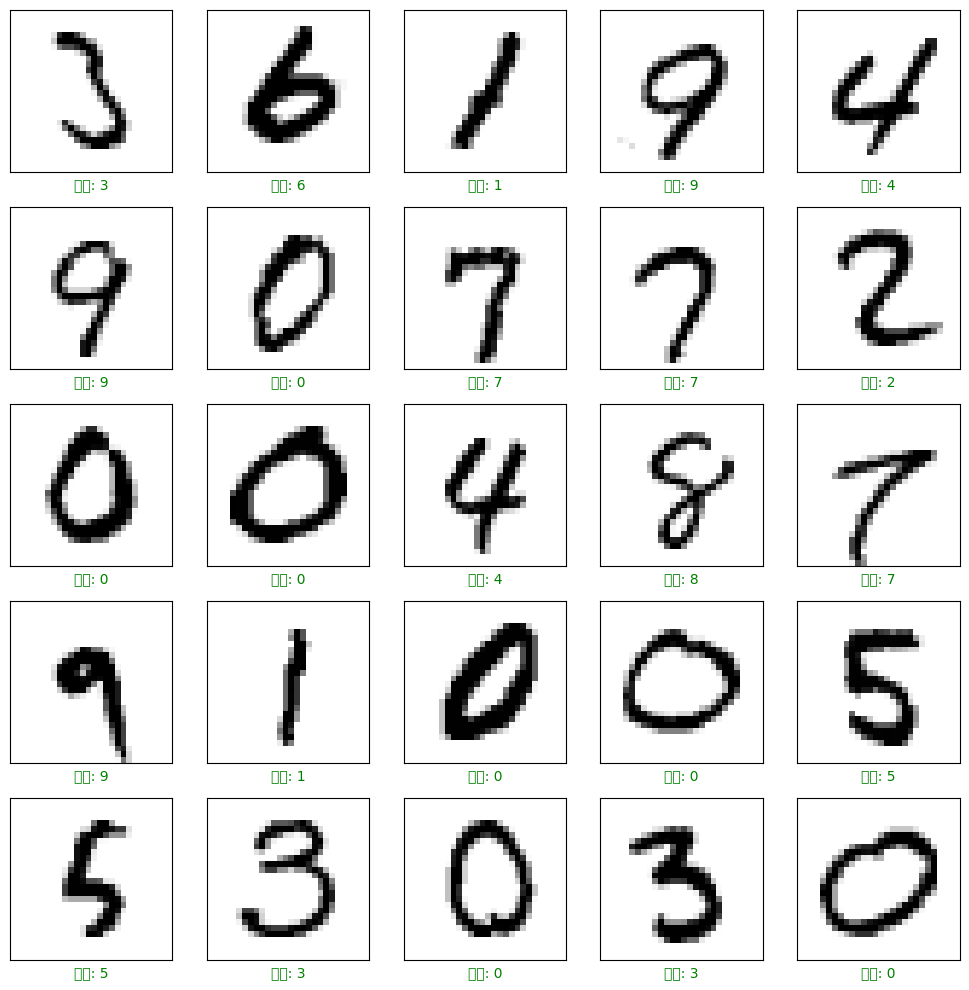

模型在测试集上的最终准确率: 98.91%


In [9]:
# 下载数据集
download_mnist()
# 准备数据集
train_dataset, test_dataset = prepare_dataset()
# 创建模型
model = LeNet5()
print("LeNet5模型结构:")
print(model)
# 训练并评估模型
accuracy = train_model(model, train_dataset, test_dataset, epochs=5)
# 保存模型
save_model(model)
# 可视化结果
visualize_results(model, test_dataset)
print(f"模型在测试集上的最终准确率: {accuracy*100:.2f}%")